<a href="https://colab.research.google.com/github/dot-spinks/machine-learning-25/blob/main/MuonSeedClassifier_QNN/QSVM/Real_Exercise_SeedClassifier_QSVM_barrel_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
This script performs binary classification using a Quantum Support Vector Machine (QSVM)
implemented with Qiskit. Unlike traditional Neural Networks, QSVM uses quantum kernels
to find optimal decision boundaries in a quantum feature space.

Key concepts for beginners:
- QSVM: Uses quantum computing to enhance classical Support Vector Machines
- Quantum Kernel: Maps classical data to quantum states and measures similarity
- Feature Map: Circuit that encodes classical data into quantum states
- No training loop needed: QSVM trains in one step (unlike iterative neural networks)

The QSVM workflow:
1. Load and preprocess data (same as neural networks)
2. Create a quantum feature map (circuit that encodes data)
3. Create a quantum kernel (measures similarity between quantum states)
4. Train QSVM classifier (one-step process)
5. Evaluate and visualize results
"""

'\nThis script performs binary classification using a Quantum Support Vector Machine (QSVM)\nimplemented with Qiskit. Unlike traditional Neural Networks, QSVM uses quantum kernels\nto find optimal decision boundaries in a quantum feature space.\n\nKey concepts for beginners:\n- QSVM: Uses quantum computing to enhance classical Support Vector Machines\n- Quantum Kernel: Maps classical data to quantum states and measures similarity\n- Feature Map: Circuit that encodes classical data into quantum states\n- No training loop needed: QSVM trains in one step (unlike iterative neural networks)\n\nThe QSVM workflow:\n1. Load and preprocess data (same as neural networks)\n2. Create a quantum feature map (circuit that encodes data)\n3. Create a quantum kernel (measures similarity between quantum states)\n4. Train QSVM classifier (one-step process)\n5. Evaluate and visualize results\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/2025_summer_QSVM/MuonSeedClassifier_QNN')

path = '/content/drive/My Drive/2025_summer_QSVM/MuonSeedClassifier_QNN/DYToLL_PU200_Spring23_NThltIter2FromL1/DYToLL_PU200_Spring23_NThltIter2FromL1_Barrel.pkl'

Mounted at /content/drive


In [ ]:
########################################################################################################
# Data IO part - Loading and preprocessing the muon seed classification data
########################################################################################################
import sys
import os
import pickle
import pandas as pd
import numpy as np

# Add parent directory to sys.path for importing custom modules
project_root = os.path.abspath(os.path.join(os.getcwd(), "."))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Project root: {project_root}")

# Import custom preprocessing functions from BDT_model
# from BDT_model.HLTIO import preprocess

# Redefine the problematic function locally with the fix
# This is a workaround because we cannot directly modify the imported module
def addDistHitL1Tk(df, addAbsDist=False):
    """
    Adds distance squared features between hits and L1 tracks to the DataFrame.
    Removed the problematic multiplication by (hitx{i}+99999.)/(hitx{i}+99999.).
    """
    for i in range(1, 4):  # For hit1, hit2, hit3
        exprd2 = f'''d2hitl1tk{i} = (l1x{i}-hitx{i})**2 + (l1y{i}-hity{i})**2 + (l1z{i}-hitz{i})**2'''
        df.eval(exprd2, engine='numexpr', inplace=True)
        # df[f'd2hitl1tk{i}'] = df[f'd2hitl1tk{i}'].fillna(-99999.) # Keeping comment as in original

    if addAbsDist:
         for i in range(1, 4):  # For hit1, hit2, hit3
              df[f'absexpd2hitl1tk{i}'] = np.sqrt(df[f'expd2hitl1tk{i}'])

    return df


print("="*80)
print("QUANTUM SUPPORT VECTOR MACHINE (QSVM) FOR MUON SEED CLASSIFICATION")
print("="*80)
print("Loading and preprocessing data...")

# Path to the original pickle file containing muon data
pkl_path = "./DYToLL_PU200_Spring23_NThltIter2FromL1/DYToLL_PU200_Spring23_NThltIter2FromL1_Barrel.pkl"

# Load the pickle file
with open(pkl_path, "rb") as file:
    data = pickle.load(file)

# Extract the DataFrame from the loaded data
df = data[0]

# Apply data quality cuts
print("Applying data quality cuts...")
# Remove unphysical pT values (pT should be positive and reasonable)
df = df[df['gen_pt'] < 1e9]  # Remove extremely high pT values
df = df[df['gen_pt'] > 0]    # Remove zero or negative pT values

# Apply setClassLabel to compute binary class labels (0 = background, 1 = signal)
# Assuming setClassLabel is not causing issues and is available in the imported module
# If not, it would need to be redefined locally as well.
from BDT_model.HLTIO import preprocess
df = preprocess.setClassLabel(df)


# Compute distance features between hits and L1 tracks
# Use the locally redefined function
df = addDistHitL1Tk(df, addAbsDist=False)

# Apply eta cuts to focus on barrel region (|eta| < 1.2)
df = df[((df['tsos_eta'] < 1.2) & (df['tsos_eta'] > -1.2))].copy()

# Define the input features for our QSVM
# These features describe the muon seed properties and track-hit distances
required_columns = [
    "expd2hitl1tk1",     # Expected distance to hit from L1 track 1
    "expd2hitl1tk2",     # Expected distance to hit from L1 track 2
    "expd2hitl1tk3",     # Expected distance to hit from L1 track 3
    "dR_L1TkMuSeedP",    # Delta R between L1 track and muon seed
    "dPhi_L1TkMuSeedP",  # Delta phi between L1 track and muon seed
    "tsos_qbp",          # Track state parameter: q/p (charge/momentum)
    "tsos_dydz",         # Track state parameter: dy/dz slope
    "tsos_dxdz",         # Track state parameter: dx/dz slope
    "tsos_err0",         # Track state error parameter 0
    "tsos_err2",         # Track state error parameter 2
    "tsos_err5",         # Track state error parameter 5
    "y_label"            # Binary class label (0=background, 1=signal)
]

# Check if all required columns exist in the dataset
missing = [col for col in required_columns if col not in df.columns]
if missing:
    print("Warning: The following required columns are missing:", missing)

# Create final dataset with only required columns
# Add the newly created d2hitl1tk columns to the required columns list
distance_columns = [f"d2hitl1tk{i}" for i in range(1, 4)]
all_required_columns = required_columns + distance_columns

# Ensure all_required_columns are in df.columns before selecting
existing_required_columns = [col for col in all_required_columns if col in df.columns]
if len(existing_required_columns) != len(all_required_columns):
    missing_after_creation = [col for col in all_required_columns if col not in df.columns]
    print(f"Warning: The following columns are still missing after attempting to create them: {missing_after_creation}")


df_final = df[existing_required_columns].copy()
df_final = df_final.fillna(-1.)  # Fill missing values with -1


print(f"Dataset shape: {df_final.shape}")
print("First few rows of processed data:")
print(df_final.head())

# Check class distribution
print("\nClass distribution in full dataset:")
print(df_final["y_label"].value_counts())

Project root: /content/drive/MyDrive/2025_summer_QSVM/MuonSeedClassifier_QNN
QUANTUM SUPPORT VECTOR MACHINE (QSVM) FOR MUON SEED CLASSIFICATION
Loading and preprocessing data...
Applying data quality cuts...
Dataset shape: (92114, 12)
First few rows of processed data:
   dR_L1TkMuSeedP  dPhi_L1TkMuSeedP  tsos_qbp  tsos_dydz  tsos_dxdz  \
0        0.004175         -0.003510 -0.023912  -0.335638  -0.038410   
1        0.005500          0.004065  0.025677  -0.411500   0.036356   
2        0.027850         -0.027783 -0.109400   1.075664   0.080918   
3        0.008985         -0.008914 -0.055924   0.417587   0.080094   
4        0.001913          0.001653  0.009154   0.334038  -0.009316   

   tsos_err0     tsos_err2     tsos_err5  y_label  d2hitl1tk1  d2hitl1tk2  \
0   0.000043  6.029049e-08  1.060757e-07      1.0    0.009054    0.338021   
1   0.000068  6.829735e-08  7.030542e-08      1.0    0.372055    0.268714   
2   0.000016  1.170655e-07  2.279720e-07      1.0    0.600656    0.732434

In [ ]:
#################################################################lin#######################################
# Data sampling and preprocessing for QSVM
########################################################################################################
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("\n" + "="*60)
print("DATA SAMPLING AND PREPROCESSING")
print("="*60)

# For QSVM tutorial, we'll use a smaller sample of data
# QSVM can be computationally intensive, so we start with manageable size
sample_size = 1000
print(f"Randomly sampling {sample_size} data points for QSVM training...")

# Randomly select indices for sampling
np.random.seed(42)  # Set seed for reproducibility
random_indices = np.random.choice(df_final.index, size=sample_size, replace=False)
df_sampled = df_final.loc[random_indices]

# Check class balance in sampled data
print("Class distribution in sampled data:")
print(df_sampled["y_label"].value_counts())

# Separate features (X) and labels (y)
X = df_sampled.drop(columns=["y_label"]).values.astype(np.float32)
y = df_sampled["y_label"].values.astype(np.int32)  # QSVM expects integer labels

print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Split data into training and test sets (80% train, 20% test)
# Stratify ensures both sets have similar class distributions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintain class balance in both splits
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Standardize features (important for quantum algorithms)
# This scales all features to have mean=0 and std=1
print("\nStandardizing features...")
scaler = StandardScaler()
scaler.fit(X_train)  # Compute scaling parameters from training data only

# Save scaling parameters for future use
scalefiles_dir = "scalefiles"
if not os.path.exists(scalefiles_dir):
    os.makedirs(scalefiles_dir)

scale_filepath = os.path.join(scalefiles_dir, "barrel_qsvm_scale.txt")
with open(scale_filepath, "w") as f_scale:
    f_scale.write("%s\n" % str(scaler.mean_.tolist()))
    f_scale.write("%s\n" % str(scaler.scale_.tolist()))
print(f"Scaling parameters saved to: {scale_filepath}")

# Apply standardization to both training and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify class distributions after splitting and scaling
print("\nFinal class distributions:")
print(f"Training set: {np.bincount(y_train)}")
print(f"Test set: {np.bincount(y_test)}")

# Reformat data to match ad_hoc_data-style output
train_features = X_train_scaled
test_features = X_test_scaled
train_labels = y_train
test_labels = y_test

# Package full dataset (combined and labeled) for compatibility
# ad_hoc_data returns (X, y) stacked as one full array
adhoc_total = (np.vstack((train_features, test_features)),
               np.hstack((train_labels, test_labels)))

# (Optional) Verify shapes
print(f"\nFormatted output:")
print(f"Train features: {train_features.shape}")
print(f"Train labels:   {train_labels.shape}")
print(f"Test features:  {test_features.shape}")
print(f"Test labels:    {test_labels.shape}")
print(f"adhoc_total[0] shape (features): {adhoc_total[0].shape}")
print(f"adhoc_total[1] shape (labels):   {adhoc_total[1].shape}")




DATA SAMPLING AND PREPROCESSING
Randomly sampling 1000 data points for QSVM training...
Class distribution in sampled data:
y_label
0.0    575
1.0    425
Name: count, dtype: int64
Feature matrix shape: (1000, 11)
Label vector shape: (1000,)
Training set size: 800
Test set size: 200

Standardizing features...
Scaling parameters saved to: scalefiles/barrel_qsvm_scale.txt

Final class distributions:
Training set: [460 340]
Test set: [115  85]

Formatted output:
Train features: (800, 11)
Train labels:   (800,)
Test features:  (200, 11)
Test labels:    (200,)
adhoc_total[0] shape (features): (1000, 11)
adhoc_total[1] shape (labels):   (1000,)


In [ ]:
########################################################################################################
# QSVM Model Definition using Qiskit
########################################################################################################
print("\n" + "="*60)
print("QUANTUM SVM MODEL SETUP")
print("="*60)

# Import required Qiskit and Qiskit Machine Learning modules
!pip install qiskit_machine_learning
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Start implementing your QSVM model here


QUANTUM SVM MODEL SETUP


In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

muon_feature_map = ZZFeatureMap(feature_dimension=11, reps=3, entanglement="linear")

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

muon_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=muon_feature_map)



In [ ]:
from sklearn.svm import SVC

muon_svc = SVC(kernel = "rbf")

muon_svc.fit(train_features, train_labels)

muon_score_callable_function = muon_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {muon_score_callable_function}")



Callable kernel classification test score: 0.94


In [ ]:
from qiskit_machine_learning.algorithms import QSVC

qsvc = QSVC(quantum_kernel=muon_kernel)

qsvc.fit(train_features, train_labels)

qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")



In [ ]:
# number of qubits is equal to the number of features
num_qubits = 11

# number of steps performed during the training procedure
tau = 100

# regularization parameter
C = 1000

from qiskit.circuit.library import ZFeatureMap
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.kernels import FidelityQuantumKernel

from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit.primitives import StatevectorSampler as Sampler

sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)

algorithm_globals.random_seed = 12345

feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

qkernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

from qiskit_machine_learning.algorithms import PegasosQSVC

pegasos_qsvc = PegasosQSVC(quantum_kernel=qkernel, C=C, num_steps=tau)

# training
pegasos_qsvc.fit(train_features, train_labels)

# testing
pegasos_score = pegasos_qsvc.score(test_features, test_labels)
print(f"PegasosQSVC classification test score: {pegasos_score}")

# Get predictions from PegasosQSVC
pegasos_preds = pegasos_qsvc.predict(test_features)

PegasosQSVC classification test score: 0.92


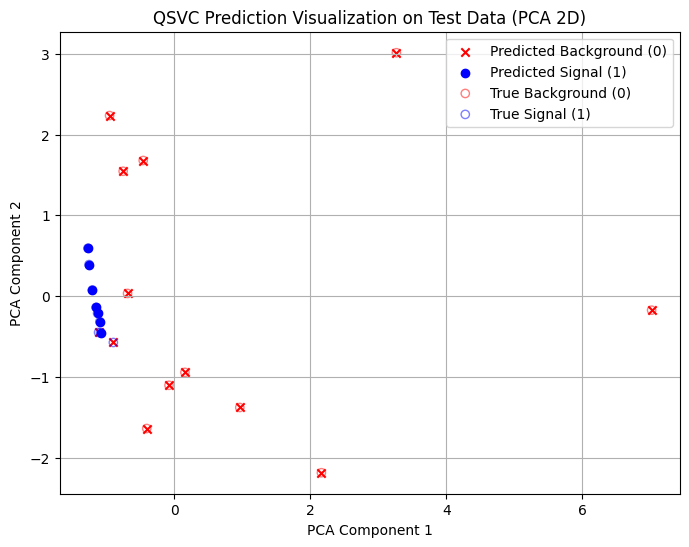

In [ ]:
#redundant

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(test_features)

# Predict labels on test set using the trained QSVC
y_pred = qsvc.predict(test_features)

plt.figure(figsize=(8, 6))

# Plot predicted classes
plt.scatter(
    X_test_2d[y_pred == 0, 0], X_test_2d[y_pred == 0, 1],
    c='red', marker='x', label='Predicted Background (0)'
)
plt.scatter(
    X_test_2d[y_pred == 1, 0], X_test_2d[y_pred == 1, 1],
    c='blue', marker='o', label='Predicted Signal (1)'
)

# Overlay true labels with transparency for comparison
plt.scatter(
    X_test_2d[test_labels == 0, 0], X_test_2d[test_labels == 0, 1],
    facecolors='none', edgecolors='red', alpha=0.5, label='True Background (0)'
)
plt.scatter(
    X_test_2d[test_labels == 1, 0], X_test_2d[test_labels == 1, 1],
    facecolors='none', edgecolors='blue', alpha=0.5, label='True Signal (1)'
)

plt.legend()
plt.title("QSVC Prediction Visualization on Test Data (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


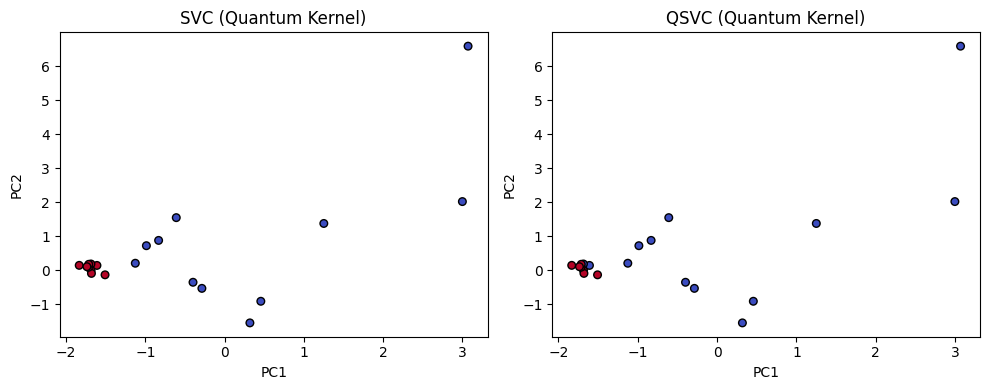

In [ ]:
#redundant

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Project features to 2D
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(train_features)
X_test_2D = pca.transform(test_features)

# Predict labels
svc_preds = muon_svc.predict(test_features)
qsvc_preds = qsvc.predict(test_features)

# Plot SVC predictions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("SVC (Quantum Kernel)")
plt.scatter(X_test_2D[:,0], X_test_2D[:,1], c=svc_preds, cmap='coolwarm', s=30, edgecolors='k')
plt.xlabel("PC1")
plt.ylabel("PC2")

# Plot QSVC predictions
plt.subplot(1,2,2)
plt.title("QSVC (Quantum Kernel)")
plt.scatter(X_test_2D[:,0], X_test_2D[:,1], c=qsvc_preds, cmap='coolwarm', s=30, edgecolors='k')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


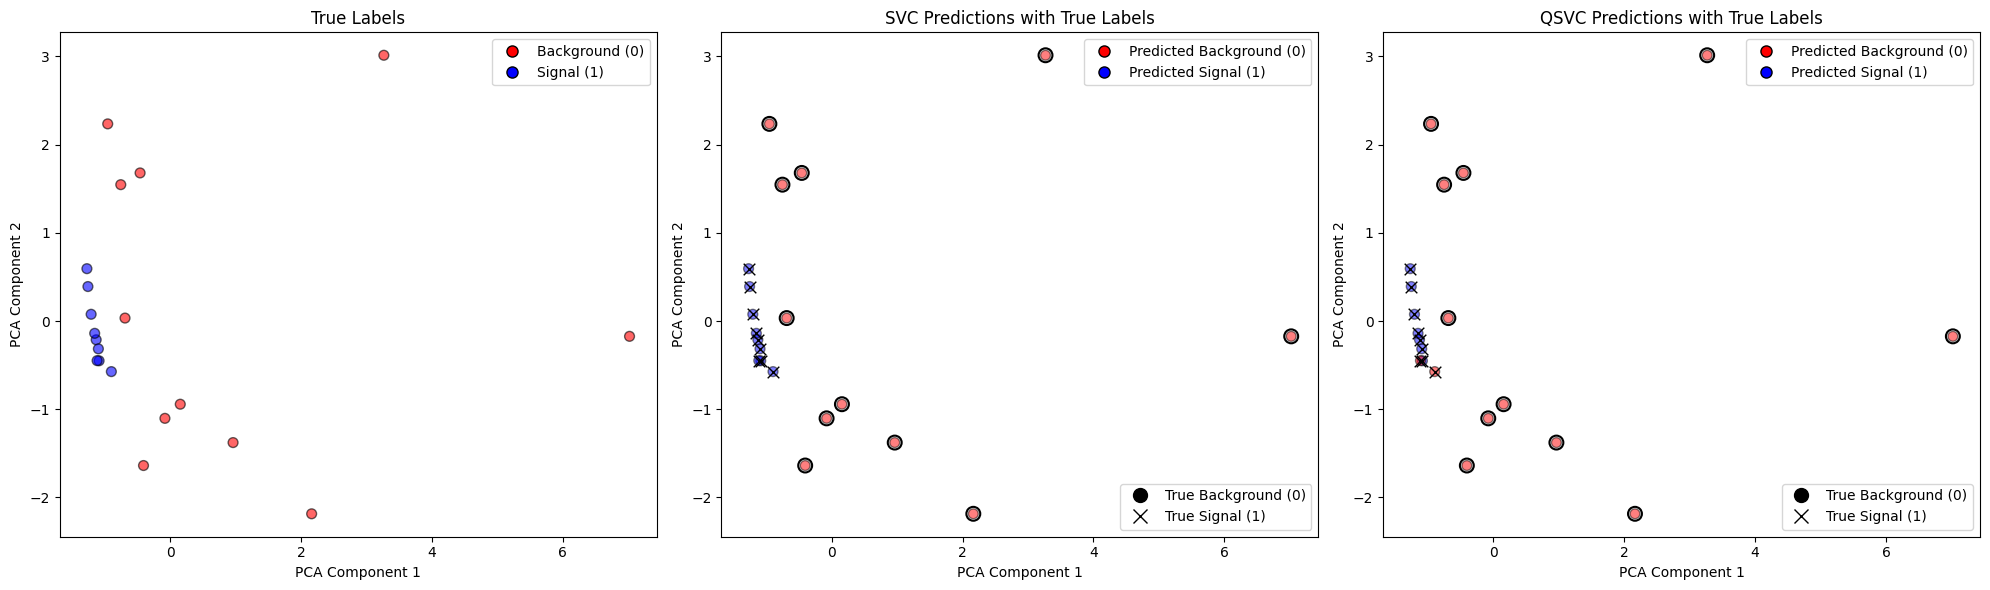

In [ ]:
#only real graph

svc_preds = muon_svc.predict(test_features)
qsvc_preds = qsvc.predict(test_features)

def plot_predictions_with_true_overlay(ax, data, preds, true_labels, title):
    # Plot predicted labels as colored points
    pred_colors = ['red' if label == 0 else 'blue' for label in preds]
    ax.scatter(data[:, 0], data[:, 1], c=pred_colors, alpha=0.5, edgecolor='k', s=50)

    # Overlay true labels with distinct markers
    idx_bg = np.where(true_labels == 0)[0]
    ax.scatter(data[idx_bg, 0], data[idx_bg, 1], facecolors='none', edgecolors='black',
               marker='o', s=100, linewidths=1.5, label='True Background (0)')

    idx_sig = np.where(true_labels == 1)[0]
    ax.scatter(data[idx_sig, 0], data[idx_sig, 1], color='black',
               marker='x', s=70, linewidths=1, label='True Signal (1)')

    ax.set_title(title)
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

    # Legend for predicted labels
    pred_legend = [
        plt.Line2D([0], [0], marker='o', color='w', label='Predicted Background (0)',
                   markerfacecolor='red', markersize=8, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Predicted Signal (1)',
                   markerfacecolor='blue', markersize=8, markeredgecolor='k')
    ]
    # Legend for true labels
    true_legend = [
        plt.Line2D([0], [0], marker='o', color='k', label='True Background (0)',
                   linestyle='None', markersize=10),
        plt.Line2D([0], [0], marker='x', color='k', label='True Signal (1)',
                   linestyle='None', markersize=10)
    ]

    leg1 = ax.legend(handles=pred_legend, loc='upper right')
    ax.add_artist(leg1)
    ax.legend(handles=true_legend, loc='lower right')

# Plot all 3 plots: true labels, SVC with true overlay, QSVC with true overlay
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Just true labels, no prediction overlay
colors_true = ['red' if label == 0 else 'blue' for label in test_labels]
axes[0].scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=colors_true, alpha=0.6, edgecolor='k', s=50)
axes[0].set_title("True Labels")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Background (0)', markerfacecolor='red', markersize=8, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', label='Signal (1)', markerfacecolor='blue', markersize=8, markeredgecolor='k')
])

# Generate Pegasos QSVC predictions
pegasos_preds = pegasos_qsvc.predict(test_features)

# Create a new figure with 4 panels
fig, axes = plt.subplots(1, 4, figsize=(26, 6))

# Panel 1: True labels
axes[0].scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=colors_true, alpha=0.6, edgecolor='k', s=50)
axes[0].set_title("True Labels")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Background (0)', markerfacecolor='red', markersize=8, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', label='Signal (1)', markerfacecolor='blue', markersize=8, markeredgecolor='k')
])

# Panel 2: SVC
plot_predictions_with_true_overlay(axes[1], X_test_2D, svc_preds, test_labels, "SVC Predictions with True Labels")

# Panel 3: QSVC
plot_predictions_with_true_overlay(axes[2], X_test_2D, qsvc_preds, test_labels, "QSVC Predictions with True Labels")

# Panel 4: Pegasos QSVC
plot_predictions_with_true_overlay(axes[3], X_test_2D, pegasos_preds, test_labels, "Pegasos QSVC Predictions with True Labels")

plt.tight_layout()
plt.show()


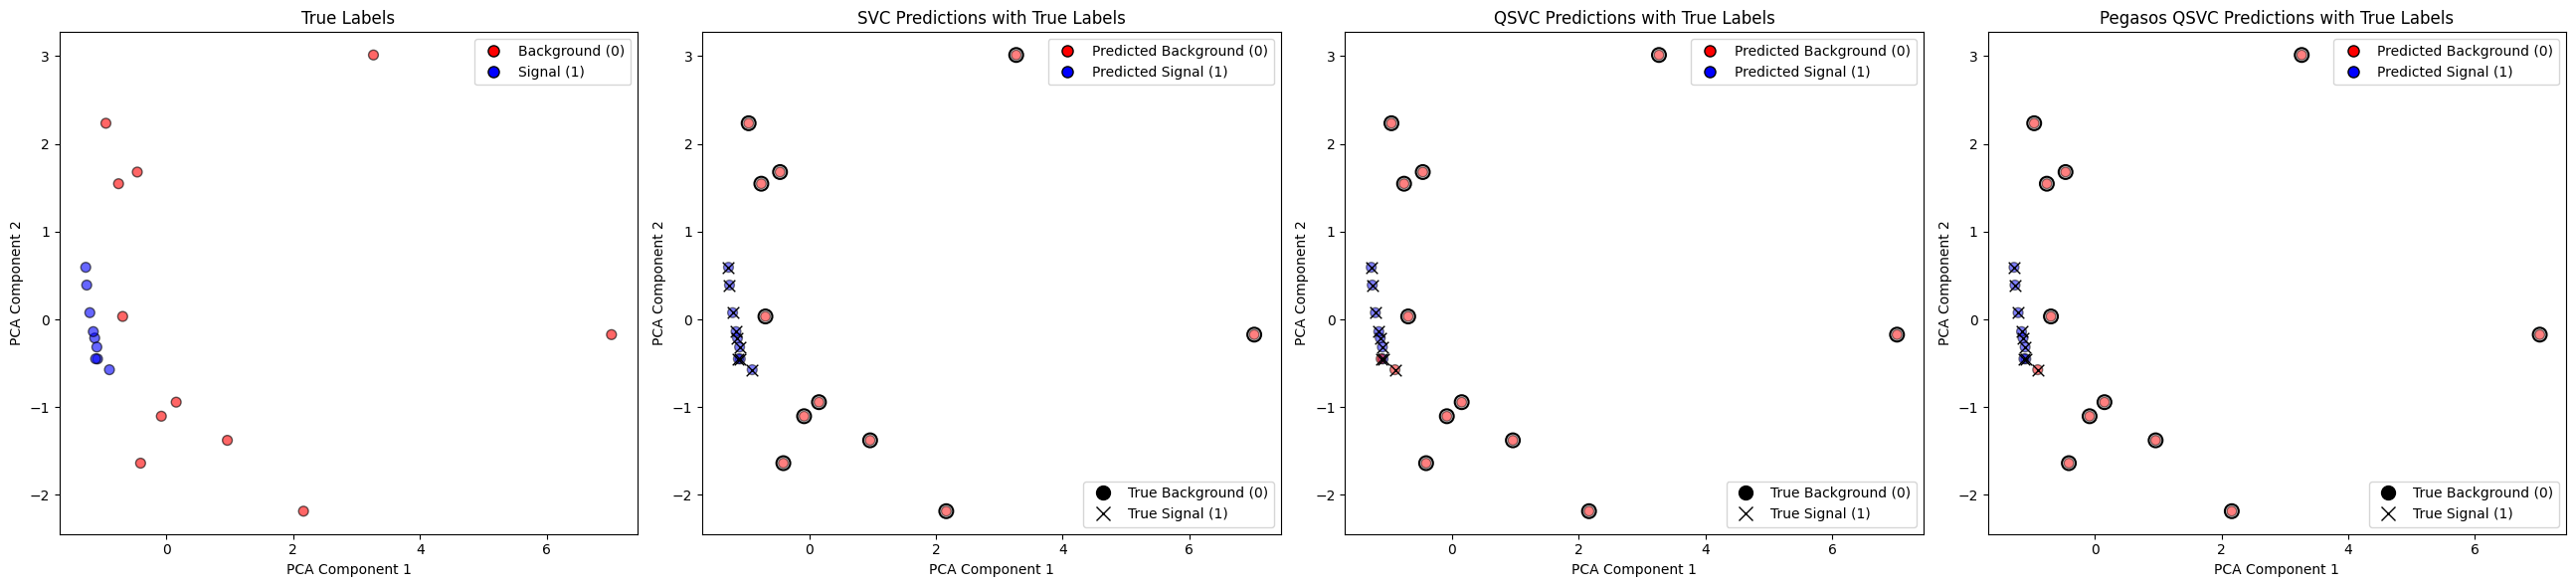

In [ ]:
#don't run
# Generate Pegasos QSVC predictions
pegasos_preds = pegasos_qsvc.predict(test_features)

# Create a new figure with 4 panels
fig, axes = plt.subplots(1, 4, figsize=(26, 6))

# Panel 1: True labels
axes[0].scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=colors_true, alpha=0.6, edgecolor='k', s=50)
axes[0].set_title("True Labels")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Background (0)', markerfacecolor='red', markersize=8, markeredgecolor='k'),
    plt.Line2D([0], [0], marker='o', color='w', label='Signal (1)', markerfacecolor='blue', markersize=8, markeredgecolor='k')
])

# Panel 2: SVC
plot_predictions_with_true_overlay(axes[1], X_test_2D, svc_preds, test_labels, "SVC Predictions with True Labels")

# Panel 3: QSVC
plot_predictions_with_true_overlay(axes[2], X_test_2D, qsvc_preds, test_labels, "QSVC Predictions with True Labels")

# Panel 4: Pegasos QSVC
plot_predictions_with_true_overlay(axes[3], X_test_2D, pegasos_preds, test_labels, "Pegasos QSVC Predictions with True Labels")

plt.tight_layout()
plt.show()
